# Optimal learning rates

In this tutorial, we'll use the MedNIST dataset to explore MONAI's `LearningRateFinder` and use it to get an initial estimate of a learning rate.

We then employ one of Pytorch's cyclical learning rate schedulers to vary the learning rate over the course of the optimisation. This has been shown to give improved results: https://arxiv.org/abs/1506.01186.

TODO:
* make a bullet list of learning points

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/modules/learning_rate.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q monai[pillow, tqdm]
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from math import ceil, floor, log10
import torch
import numpy as np
from sklearn.metrics import classification_report
from torch.utils.data import DataLoader
from tqdm import trange

from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.metrics import compute_roc_auc
from monai.networks.nets import densenet121
from monai.networks.utils import eval_mode
from monai.optimizers import LearningRateFinder
from monai.transforms import (
    AddChanneld,
    Compose,
    LoadImaged,
    RandFlipd,
    RandRotated,
    RandZoomd,
    ScaleIntensityd,
    ToTensord,
)
from monai.utils import set_determinism

print_config()

MONAI version: 0.4.0+66.g028a965.dirty
Numpy version: 1.19.5
Pytorch version: 1.7.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 028a965b208e2ef4265d51ec9c7ec8bd43b83359

Optional dependencies:
Pytorch Ignite version: 0.4.2
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.1.0
Tensorboard version: 2.4.0
gdown version: 3.12.2
TorchVision version: 0.8.2
ITK version: 5.1.2
tqdm version: 4.51.0
lmdb version: 1.0.0
psutil version: 5.8.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/rbrown/data/MONAI


## Set deterministic training for reproducibility

In [4]:
set_determinism(seed=0)

## Define MONAI transforms, Dataset and Dataloader to pre-process data

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        RandRotated(keys="image", range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipd(keys="image", spatial_axis=0, prob=0.5),
        RandZoomd(keys="image", min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensord(keys="image"),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys="image"),
        AddChanneld(keys="image"),
        ScaleIntensityd(keys="image"),
        ToTensord(keys="image"),
    ]
)

In [6]:
# Set fraction of images used for testing to be very high, then don't use it. In this way, we can reduce the number 
# of images in both train and val. Makes it faster and makes the training a little harder.
def get_data(transforms, section):
    ds = MedNISTDataset(
        root_dir=root_dir,
        transform=transforms,
        section=section,
        download=True,
        num_workers=10,
        val_frac=.0005,
        test_frac=0.995,
    )
    loader = DataLoader(ds, batch_size=300, shuffle=True, num_workers=10)
    
    return ds, loader

train_ds, train_loader = get_data(train_transforms, "training")
val_ds, val_loader = get_data(train_transforms, "validation")

print(len(train_ds))
print(len(val_ds))
num_classes = train_ds.get_num_classes()

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /home/rbrown/data/MONAI/MedNIST.tar.gz exists, skip downloading.
extracted file /home/rbrown/data/MONAI/MedNIST exists, skip extracting.


Loading dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
file /home/rbrown/data/MONAI/MedNIST.tar.gz exists, skip downloading.
extracted file /home/rbrown/data/MONAI/MedNIST exists, skip extracting.


Loading dataset: 100%|██████████| 25/25 [00:00<00:00, 1221.23it/s]

249
25


## Randomly pick images from the dataset to visualize and check

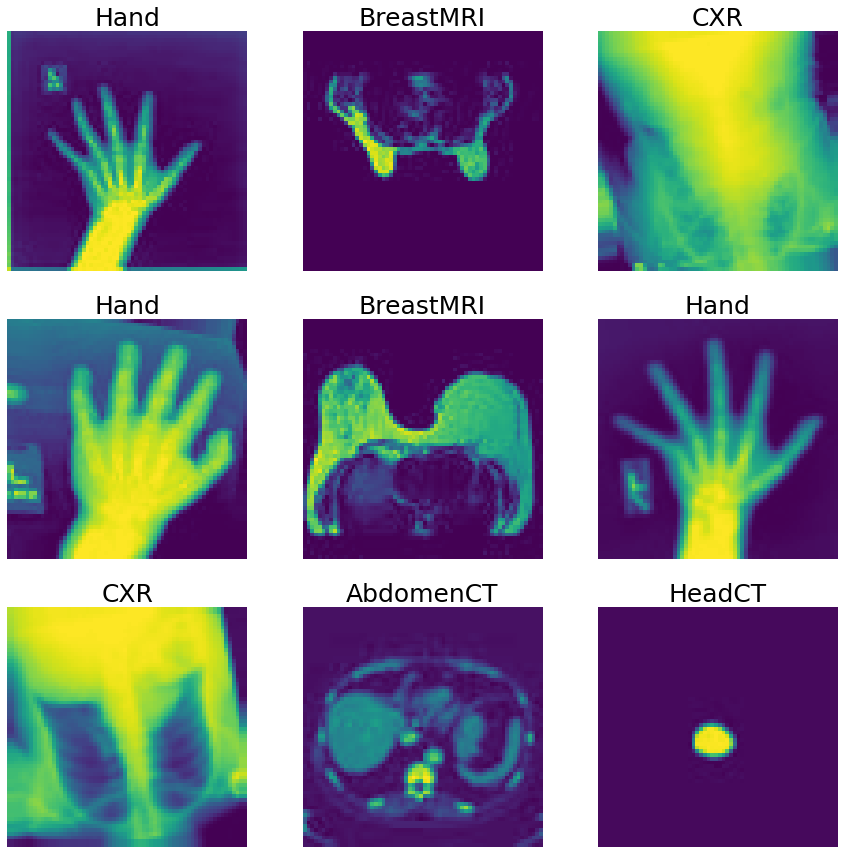

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15), facecolor='white')
for i, k in enumerate(np.random.randint(len(train_ds), size=9)):
    data = train_ds[k]
    im, title = data["image"], data["class_name"]
    ax = axes[i//3, i%3]
    im_show = ax.imshow(im[0])
    ax.set_title(title, fontsize=25)
    ax.axis('off')

## Define network and optimizer

1. Set learning rate for how much the model is updated per batch.
1. Set total epoch number, as we have shuffle and random transforms, so the training data of every epoch is different.
And as this is just a get start tutorial, let's just train 4 epochs.
If train 10 epochs, the model can achieve 100% accuracy on test dataset.
1. Use DenseNet from MONAI and move to GPU devide, this DenseNet can support both 2D and 3D classification tasks.
1. Use Adam optimizer.

In [8]:
lr = 1e-5
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_function = torch.nn.CrossEntropyLoss()
model = densenet121(spatial_dims=2, in_channels=1,
                    out_channels=num_classes).to(device)

# Estimate optimal learning rate

Use MONAI's `LearningRateFinder` to get an initial estimate of a learning rate. Assume that it's in the range 1e-5, 1e-2. If that weren't the case (which we'd notice in the plot), we could just try again over a larger/different window.

We then extract the learning rate with the steepest gradient, and set the upper and lower learning rates of a cyclical optimsation to be the nearest powers of 10 above and below this value.

Computing optimal learning rate:  95%|█████████▌| 19/20 [00:41<00:02,  2.20s/it]


Stopping early, the loss has diverged
Resetting model and optimizer


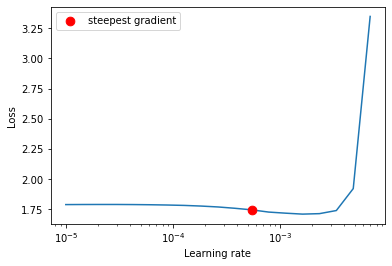

In [9]:
lower_lr, upper_lr = 1e-5, 1e-2
optimizer = torch.optim.Adam(model.parameters(), lower_lr)
lr_finder = LearningRateFinder(model, optimizer, loss_function, device=device)
lr_finder.range_test(train_loader, val_loader, end_lr=upper_lr, num_iter=20)
ax=plt.subplots(1, 1, facecolor='white')[1]
_ = lr_finder.plot(ax=ax)

In [10]:
steepest_lr = lr_finder.get_steepest_gradient()[0]
lower_lr = 10 ** floor(log10(steepest_lr))
upper_lr = 10 ** ceil(log10(steepest_lr))
print(f"lr w/ steepest gradient: {steepest_lr:e}")
print(f"lower: {lower_lr:1.0e}, upper: {upper_lr:1.0e}")

lr w/ steepest gradient: 5.455595e-04
lower: 1e-04, upper: 1e-03


## Model training

Execute a typical PyTorch training that run epoch loop and step loop, and do validation after every epoch.
Will save the model weights to file if got best validation accuracy.

In [11]:
%matplotlib notebook
# def get_colour(q):
#     return plt.rcParams['axes.prop_cycle'].by_key()['color'][q]

def plot_range(data, wrapped_generator):
    plt.ion()
    for q in data.values():
        for d in q.values():
            if isinstance(d, dict):
                ax = d["line"].axes
                ax.legend()
                fig = ax.get_figure()
    fig.show()
    
    for i in wrapped_generator:
        for q in data.values():
            for d in q.values():
                if isinstance(d, dict):
                    d["line"].set_data(d["x"], d["y"])
                    ax = d["line"].axes
                    ax.legend()
                    ax.relim()
                    ax.autoscale_view()
        fig.canvas.draw()
        yield i

In [12]:
def train(max_epochs, axes, data):
    for z, d in enumerate(data.keys()):
        data[d]["model"] = densenet121(
            spatial_dims=2, in_channels=1,
            out_channels=num_classes).to(device)

        if "lr_lims" in data[d]:
            data[d]["optimizer"] = torch.optim.Adam(
                data[d]["model"].parameters(), data[d]["lr_lims"][0])
            # In the paper referenced at the top of this notebook, a step
            # size of 8 times the number of iterations per epoch is suggested.
            step_size = 8 * len(train_loader)
            data[d]["scheduler"] = torch.optim.lr_scheduler.CyclicLR(
                data[d]["optimizer"], base_lr=data[d]["lr_lims"][0], 
                max_lr=data[d]["lr_lims"][1], step_size_up=step_size,
                cycle_momentum=False,
            )
        else:
            data[d]["optimizer"] = torch.optim.Adam(
                data[d]["model"].parameters(), data[d]["lr_lim"])

        for q, i in enumerate(["train", "auc", "acc"]):
            data[d][i] = {"x":[], "y":[]}
            data[d][i]["line"], = axes[q].plot(
                data[d][i]["x"], data[d][i]["y"], label=d)
#                 get_colour(z), label=d)

        val_interval = 1
    
    for epoch in plot_range(data, trange(max_epochs)):
        
        for d in data.keys():
            data[d]["epoch_loss"] = 0
        for batch_data in train_loader:
            inputs = batch_data["image"].to(device)
            labels = batch_data["label"].to(device)
            
            for d in data.keys():
                data[d]["optimizer"].zero_grad()
                outputs = data[d]["model"](inputs)
                loss = loss_function(outputs, labels)
                loss.backward()
                data[d]["optimizer"].step()
                if "scheduler" in data[d]:
                    data[d]["scheduler"].step()
                data[d]["epoch_loss"] += loss.item()
        for d in data.keys():
            data[d]["epoch_loss"] /= len(train_loader)
            data[d]["train"]["x"].append(epoch+1)
            data[d]["train"]["y"].append(data[d]["epoch_loss"])

        if (epoch + 1) % val_interval == 0:
            with eval_mode(*[data[d]["model"] for d in data.keys()]):
                for d in data:
                    data[d]["y_pred"] = torch.tensor([], dtype=torch.float32, device=device)
                y = torch.tensor([], dtype=torch.long, device=device)
                for val_data in val_loader:
                    val_images = val_data["image"].to(device)
                    val_labels = val_data["label"].to(device)
                    for d in data:
                        data[d]["y_pred"] = torch.cat(
                            [data[d]["y_pred"], data[d]["model"](val_images)], dim=0)
                    y = torch.cat([y, val_labels], dim=0)
                
                for d in data:
                    auc_metric = compute_roc_auc(
                        data[d]["y_pred"], y, to_onehot_y=True, softmax=True)
                    data[d]["auc"]["x"].append(epoch+1)
                    data[d]["auc"]["y"].append(auc_metric)
                
                    acc_value = torch.eq(data[d]["y_pred"].argmax(dim=1), y)
                    acc_metric = acc_value.sum().item() / len(acc_value)
                    data[d]["acc"]["x"].append(epoch+1)
                    data[d]["acc"]["y"].append(acc_metric)

<IPython.core.display.Javascript object>


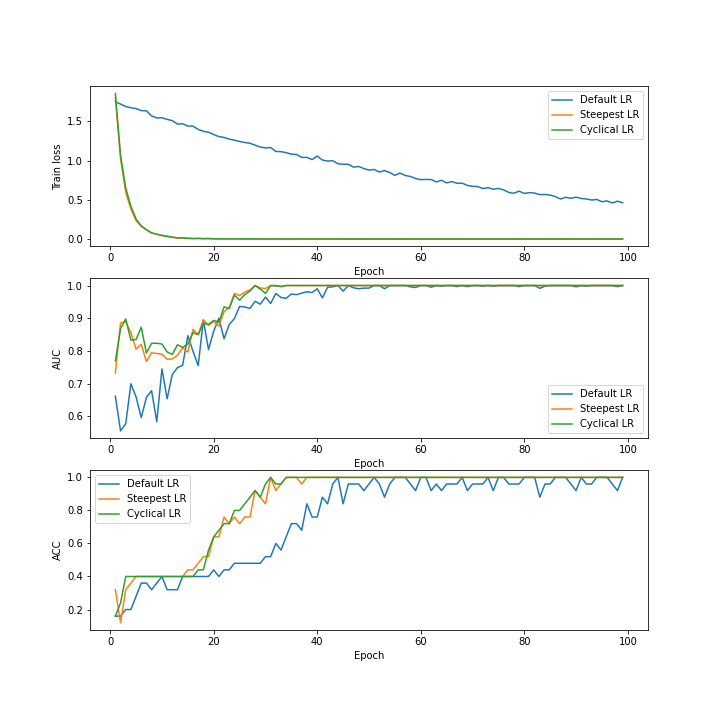

100%|██████████| 100/100 [04:36<00:00,  2.77s/it]


In [13]:
fig, axes=plt.subplots(3, 1, figsize=(10, 10), facecolor='white')
for ax in axes:
    ax.set_xlabel('Epoch')
axes[0].set_ylabel('Train loss')
axes[1].set_ylabel('AUC')
axes[2].set_ylabel('ACC')

max_epochs = 100
data = {}
data["Default LR"] = {"lr_lim": 1e-5}
data["Steepest LR"] = {"lr_lim": steepest_lr}
data["Cyclical LR"] = {"lr_lims": (0.8*steepest_lr, 1.2*steepest_lr)}

train(max_epochs, axes, data)

## Cleanup data directory

Remove directory if a temporary was used.

In [14]:
if directory is None:
    shutil.rmtree(root_dir)